# Investigating the themoviedb.org dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

themoviedb.org (tmdb) is a free and open user-generated movie and TV metadata database. Tmdb is widely used to augment various 3rd party media applications such as Plex and Kodi with data about hundreds of thousands of movies and tv shows. The dataset explored here is a subset of approximately 10,000 movies that were released between 1960 and 2015.

In this report I will be investigating what traits lead to a film being financially successful. Specifically, What  are film finances like in general? Are there more financially successful or unsuccessful films? How much does the average film make? what genres show up most often in profitable and unprofitable films? I hope to glean insight about the answers to these questions by analyzing the tmdb dataset. 

<a id='wrangling'></a>
## Data Wrangling

### General Properties
The tmdb dataset contains many types of data from popularity to cast members so it's worth going through here what is and isn't going to be useful for our analysis. 

First we have some basic identification that doesn't directly provide any useful data. Namely, The ID numbers, title, overview, tagline, and homepage url don't seem particularly interesing in and of themselves so won't factor heavily into our analysis. 

Next comes the textual data: genres, production companies, directors, cast, and keywords. These labels will be useful for splitting up data into meaningful categories. 

The real meat of tmdb is the numerical and time data. The budget and revenue (both adjusted and canonical), user votes, popularity, runtime, and release date will all prove highly useful for teasing out financial trends in the data. 

Let's load the dataset now.

In [25]:
#key plotting and formatting libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

#displays graphs inline
import pprint 
pp = pprint.PrettyPrinter(indent=4)

#libraries to help with loading the database
import csv
import io
import math
from datetime import datetime

#libraries for helping to analyze data
from collections import Counter, defaultdict

In [38]:
#read in the database as a list of dictionaries
tmdb_file = open('tmdb-movies.csv','r')
reader = csv.DictReader(tmdb_file)
database = []
for row in reader:
    database.append(
        {key:value.split('|') 
            for key,value in row.items()}
    )

Now that the database is loaded we check for data integrity.

In [39]:
print(len(database))

10866


In [40]:
pp.pprint(database[139])

{   'budget': ['0'],
    'budget_adj': ['0'],
    'cast': ['Margot Robbie', 'Chiwetel Ejiofor', 'Chris Pine'],
    'director': ['Craig Zobel'],
    'genres': ['Drama', 'Science Fiction', 'Thriller'],
    'homepage': ['http://www.facebook.com/ZforZachariah'],
    'id': ['193687'],
    'imdb_id': ['tt1598642'],
    'keywords': [   'love triangle',
                    'based on novel',
                    'jealousy',
                    'radiation',
                    'tractor'],
    'original_title': ['Z for Zachariah'],
    'overview': [   'In the wake of a nuclear war, a young woman survives on '
                    'her own, fearing she may actually be the proverbial last '
                    'woman on earth, until she discovers the most astonishing '
                    'sight of her life: another human being. A distraught '
                    'scientist, heâ€™s nearly been driven mad by radiation '
                    'exposure and his desperate search for others. A fragile, '
  

### Data Cleaning
It appears that our loading operation was a success! We do however have another set of problems: everything is a string type (because lists can't hold heterogenyous datatypes), single valued data is contained in a list, and some fields are empty <b> u'budget': [u'0']</b>. Let's identify what data needs to be changed and to what. 

All single-valued fields will be converted from lists into basic types with [0]

['example'][0] -> 'example'

##### Strings:
<ul>
    <li>overview</li>
    <li>original_title </li>
    <li>tagline </li>
    <li>homepage</li>
</ul>

##### Lists of Strings:
<ul>
    <li>genres</li>
    <li>production_companies</li> 
    <li>director </li>
    <li>keywords </li>
    <li>cast </li>
</ul>
These data are fine to leave as is and need no further conversion

##### Integers:
<ul>
    <li>runtime (in minutes)</li>
    <li>vote_count </li>
    <li>budget </li>
    <li>revenue </li>
    <li>id</li>
    <li>imdb_id</li>
    <li>release_year</li>
    <li>budget_adj </li>
    <li>revenue_adj</li>
</ul>
These data can be converted to integers using the int() function

##### Floating point:
<ul>
    <li>vote_average (float)</li>
    <li>popularity (float 0-33)</li>
</ul>
These data can be converted using the float() function

##### Dates:

<ul>
    <li>release_date (10/18/11 mm/dd/yy)</li>
</ul>

The release date would be more convenient as a datetime object and while we are at it release_month and release_day counterparts to the release_year field could prove useful.

In [41]:
for entry in database:
    # data we will end up using
    entry['release_year'] = int(entry['release_year'][0])
    entry['runtime'] = int(entry['runtime'][0])
    entry['budget_adj'] = int(math.floor(float(entry['budget_adj'][0])))
    entry['revenue_adj'] = int(math.floor(float(entry['revenue_adj'][0])))
    entry['profit'] = float(float(entry['revenue_adj'])/float((entry['budget_adj']+1)))
    entry['id'] = int(entry['id'][0])
    entry['original_title'] = entry['original_title'][0]
    
    # data that has been cleaned in case anyone wants to modify this notebook but will not be used here
    entry['homepage'] = entry['homepage'][0]
    entry['tagline'] = entry['tagline'][0]
    entry['overview'] = entry['overview'][0]
    entry['release_date'] = pd.to_datetime(entry['release_date'][0],format='%m/%d/%y')
    entry['vote_count'] = int(entry['vote_count'][0])
    entry['vote_average'] = float(entry['vote_average'][0])
    entry['imdb_id'] = entry['imdb_id'][0]
    entry['popularity'] = float(entry['popularity'][0])
    entry['budget'] = int(entry['budget'][0])
    entry['revenue'] = int(entry['revenue'][0])    

In [42]:
pp.pprint(database[139])

{   'budget': 0,
    'budget_adj': 0,
    'cast': ['Margot Robbie', 'Chiwetel Ejiofor', 'Chris Pine'],
    'director': ['Craig Zobel'],
    'genres': ['Drama', 'Science Fiction', 'Thriller'],
    'homepage': 'http://www.facebook.com/ZforZachariah',
    'id': 193687,
    'imdb_id': 'tt1598642',
    'keywords': [   'love triangle',
                    'based on novel',
                    'jealousy',
                    'radiation',
                    'tractor'],
    'original_title': 'Z for Zachariah',
    'overview': 'In the wake of a nuclear war, a young woman survives on her '
                'own, fearing she may actually be the proverbial last woman on '
                'earth, until she discovers the most astonishing sight of her '
                'life: another human being. A distraught scientist, heâ€™s '
                'nearly been driven mad by radiation exposure and his '
                'desperate search for others. A fragile, imperative strand of '
                'trust 

Fantastic! We can now move these data into a pandas dataframe and make use of some very helpful functions to drop duplicates and rows we don't plan on using.

In [43]:
pandadb = pd.DataFrame(data=database)

In [44]:
pandadb.iloc[139]

id                                                                 193687
imdb_id                                                         tt1598642
popularity                                                       1.161812
budget                                                                  0
revenue                                                            118483
original_title                                            Z for Zachariah
cast                        [Margot Robbie, Chiwetel Ejiofor, Chris Pine]
homepage                            http://www.facebook.com/ZforZachariah
director                                                    [Craig Zobel]
tagline                 After the end of the world she thought she was...
keywords                [love triangle, based on novel, jealousy, radi...
overview                In the wake of a nuclear war, a young woman su...
runtime                                                                97
genres                                

The pandas display is much nicer to read and duplicate checking is now very simple. 

In [45]:
print(len(pandadb))
pandadb = pandadb.drop_duplicates('id')
print(len(pandadb))

10866
10865


We found precisely one duplicate entry. It happened to be the 2010 TEKKEN film at entries 2089 and 2090.

We will now remove some of the less useful columns so they don't clutter our outputs.

In [46]:
pandadb=pandadb.drop(['cast','director','homepage','imdb_id',
              'keywords','overview','production_companies',
              'tagline','revenue','budget','popularity',
              'vote_count','vote_average','release_date'],axis=1)
print(pandadb.iloc[139])

id                                            193687
original_title                       Z for Zachariah
runtime                                           97
genres            [Drama, Science Fiction, Thriller]
release_year                                    2015
budget_adj                                         0
revenue_adj                                   109004
profit                                      109004.0
Name: 139, dtype: object


That output is far easier to parse but I also see that there is a null value for the budget. We should remove those (and other unreasonable values) as well before we start exploring.

In [179]:
pandadb = pandadb[(pandadb.budget_adj>1) & (pandadb.revenue_adj >1) & 
                (pandadb.release_year<2016) & (pandadb.release_year>0) ]
print(len(pandadb))

3819


<a id='eda'></a>
## Exploratory Data Analysis

### What are the finances of films like and how profitable are they to make?

Let's look at the budget data to get a sense for what sort of money films cost to make.

Text(0.5, 0, 'Budget in $(adj)')

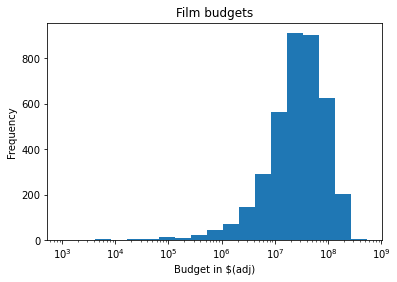

In [131]:
_PLOT = pandadb['budget_adj'].plot(kind="hist",bins=[2**x for x in range(10,30)],logx=True)
_PLOT.set_title("Film budgets")
_PLOT.set_xlabel("Budget in $(adj)")

Let's print out some statistics as well.

In [132]:
pandadb['budget_adj'].describe().apply(lambda x: format(int(round(x,0))))

count         3819
mean      44543600
std       44834508
min           6310
25%       13352838
50%       30306534
75%       60767198
max      425000000
Name: budget_adj, dtype: object

That is quite the range! From a few thousand dollars to the GDP of a small country films are certainly not lacking in monetary diversity. Let's see if all that money was put to good use.

Text(0.5, 0, 'Revenue in $(adj)')

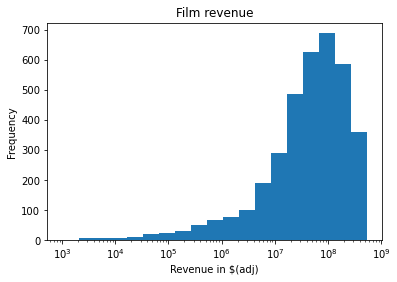

In [133]:
_PLOT = pandadb['revenue_adj'].plot(kind="hist",bins=[2**x for x in range(10,30)],logx=True)
_PLOT.set_title("Film revenue")
_PLOT.set_xlabel("Revenue in $(adj)")

The revenue plot is so similar to the  budget plot that comparing them directly seems difficult to do. Let's try looking at the differences between revenue and budget instead.

In [134]:
pandadb['profit'] = pandadb['revenue_adj']-pandadb['budget_adj']

In [135]:
max(pandadb['profit'])

2750136651

Text(0.5, 0, 'Profit in $(adj)')

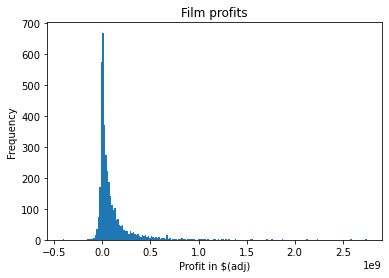

In [136]:
_PLOT=pandadb['profit'].plot(kind="hist",bins=200)
_PLOT.set_title("Film profits")
_PLOT.set_xlabel("Profit in $(adj)")

Assuming our sample is even close to representative of all films the film market seems remarkably healthy. The typical film makes a decent amount of money, only a minority of films are made at a loss and there is a long and thin tail of extremely succesful films. Let's get some more hard numbers on this and move onto the next question.

In [137]:
pandadb['profit'].describe().apply(lambda x: format(int(round(x,0))))

count          3819
mean       93713095
std       194682608
min      -413912431
25%        -1480390
50%        28072991
75%       108222527
max      2750136651
Name: profit, dtype: object

It appears that the average film is very profitable and made around 93 million dollars!
This is obviously skewed upwards by films that made billions of dollars but even the median film netted a very respectable 28 million and the majority of films in this dataset (looks to be around 70%) were profitable. let's split this dataset into 2 and compare films that were and were not profitable.

In [150]:
mademoney = pandadb.loc[pandadb['profit']>0]
lostmoney = pandadb.loc[pandadb['profit']<0]
#we're excluding 4 results that made back exactly what they cost
print(mademoney['profit'].describe().apply(lambda x: format(float(round(x,0)))))
print()
print(lostmoney['profit'].describe().apply(lambda x: format(float(round(x,0)))))

count          2760.0
mean      136194493.0
std       213878262.0
min            8562.0
25%        20805653.0
50%        61920459.0
75%       156053086.0
max      2750136651.0
Name: profit, dtype: object

count          1056.0
mean      -17051602.0
std        22554340.0
min      -413912431.0
25%       -21007685.0
50%       -10452680.0
75%        -4282174.0
max           -4749.0
Name: profit, dtype: object


So the average successful film made 136 million dollars and the average unsuccessful film lost 17 million dollars. Let's see what genres go into making a film a financial failure/success. 

### How does profitability relate to genre.

In [153]:
#takes in a list of lists.
#returns a pandas series where all values have been flattened:
#occurances of each unique value are counted
#and counts are normalized to percentages
#[[1],[1],[2],[2],[3]] -> {1:40%,2:40%,3:20%}
def flattencountnorm(lol):
    _ = Counter([x for lis in lol for x in lis])
    total = float(sum(_.values())) 
    ret = {}
    for k,v in _.items():
        ret[k] = (float(v)/total*100.0) 
    return pd.Series(ret)

Text(0, 0.5, '% more prevalent in profitable films')

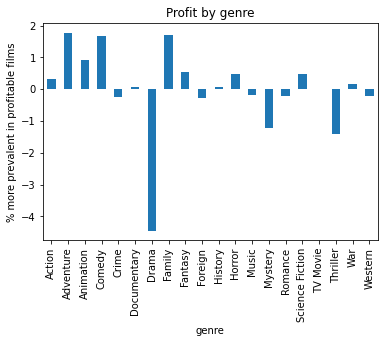

In [155]:
lostnorm = flattencountnorm(lostmoney['genres'])
madenorm = flattencountnorm(mademoney['genres'])
_PLOT = (madenorm-lostnorm).plot(kind="bar")
_PLOT.set_title("Profit by genre")
_PLOT.set_xlabel("genre")
_PLOT.set_ylabel("% more prevalent in profitable films")

This graph shows the difference in prevalence of certain genres between successful and unsuccessful films so a number of +1 means that that genre appeared more in successful films than unsuccessful ones. The clear outlier is dramas which seem to be highly associated with films that lost money. This link is tenuous due to the incompleteness of our dateset (which we're only using a third of!) but it still suggests a strong trend. Mystery and Thrillers also drive losses more often than not while Adventure, Comedy, Family films are the heavy hitters in consistent profitability with animation a distant fourth. Also notice that TV movies didn't exist in the set of films that lost money so that bar is absent.

In [162]:
set(madenorm.keys())-set(lostnorm.keys())

{'TV Movie'}

## Profit and time
#### or How profit relates to runtime and release date 

First let's see what sort of runtimes films tend to have

Text(0.5, 0, 'runtime (minutes)')

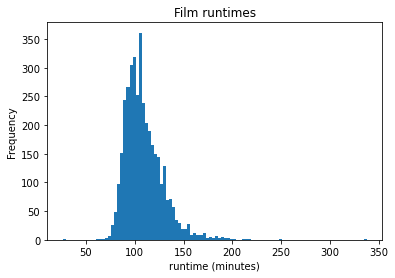

In [164]:
_PLOT = pandadb['runtime'].plot(kind="hist", bins=100)
_PLOT.set_title("Film runtimes")
_PLOT.set_xlabel("runtime (minutes)")

It sems that The vast majority of films are between one hour and three hours and are normally distributed and centered around 100 minutes. Now let's plot how well runtime corelates with profit.

Text(0.5, 1.0, 'Film runtime vs profit')

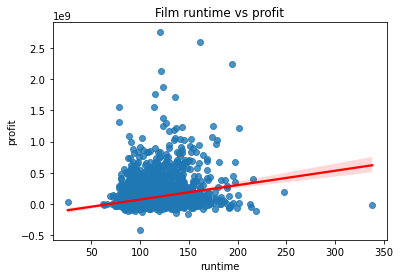

In [173]:
_PLOT = sns.regplot(x=pandadb['runtime'],y=pandadb['profit'], line_kws={'color':'red'})
_PLOT.set_title("Film runtime vs profit")

It seems that runtime and profit have a very weak positive correlation. How about the other time datatype we have to work with: release date.

Text(0.5, 0, 'release year')

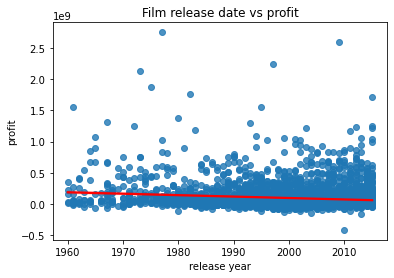

In [175]:
_PLOT = sns.regplot(x=pandadb['release_year'],y=pandadb['profit'],line_kws={'color':'red'})
_PLOT.set_title("Film release date vs profit")
_PLOT.set_xlabel("release year")

A correlation that close to 0 is an impressive result. It seems that even though the size of the film market is growing year on year the actual profitability of the average film is more or less constant. 

<a id='conclusions'></a>
## Conclusions

As a recap of our most revealing results:
<ul>
    <li>The typical film turns a substantial profit</li>
    <li>Most films are financially successful with a few runaway successes</li>
    <li>Dramas are consistently unsuccessful to a suprising degree</li>
    <li>film profitability has been constant for decades</li>
</ul>
While these results are certainly suggestive of strong trends in the data it's important to note that these conclusions are merely well informed speculation. We had around 11,000 datapoints of which we only used a little under 4,000. That may sound like a lot but according to imdb (another movie database) there were over 5000 feature films released in 2006 alone. This means we were only operating on at best a random sample and more likely a sample heavily biased by the interests of the tmdb contributors and generally (popular) films that we have financial data for. Our analysis still has merit at providing insight into the financial state of films but proper statistical testing, or at least a more complete dataset, would be required to draw any truly meaningful conclusions.